<a href="https://colab.research.google.com/github/emmacampo/image_classification_CNN/blob/main/CNN_COVID_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: COVID-19 Image Classification

## Problem Statement

### Context

Covid-19 is a fast-growing disease that affects human health severly. Patients diagonised with this condition suffers from lung infection. The medical community has recently released vaccines which have a slower effect in increasing the immunity. This virus has impacted various countries' human health and financial standing.

Deep learning algorithms have recently used image classification to identify medical images. Convolutional Neural Networks (CNN) can be widely utilized to identify COVID-19 to assist radiologists in medical analysis by classifying patients who are healthy, have viral pneumonia, or are affected by COVID using X-ray pictures of the lungs.

### Objective

The aim of this project is to Build a Convolutional Neural Network to differentiate an X-ray image of a person affected with covid from that of a healthy person or a person who has viral pneumonia(fever).

### Data Dictionary

- This dataset contains training set images of 3 classes which are converted into numpy arrays.

- The dataset comprises 3 classes:
  - COVID-19: The patient who is effected due to covid.
  - Viral Pneumonia: This is a viral fever which has similar characteristics like fever and cought that of Covid but is not covid.
  
  - Normal- A healthy Person with no symptoms of covid or fever.
- The data file names are:
  - CovidImages.npy
  - CovidLabels.csv

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2  # Importing openCV for image processing
import seaborn as sns

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

# Display images using OpenCV
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import ReduceLROnPlateau

## Loading the dataset

In [ ]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')
labels= pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CovidLabels.csv")

Mounted at /content/drive


In [ ]:
images= np.load("/content/drive/MyDrive/Colab_Notebooks/CovidImages.npy")

## Data Overview

### Understand the shape of the dataset

In [ ]:
print(labels.shape)
print(images.shape)

(251, 1)
(251, 128, 128, 3)


There are 251 RGB images of shape 128 x 128 X 3. Each RGB image has 3 channels

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category X-ray images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

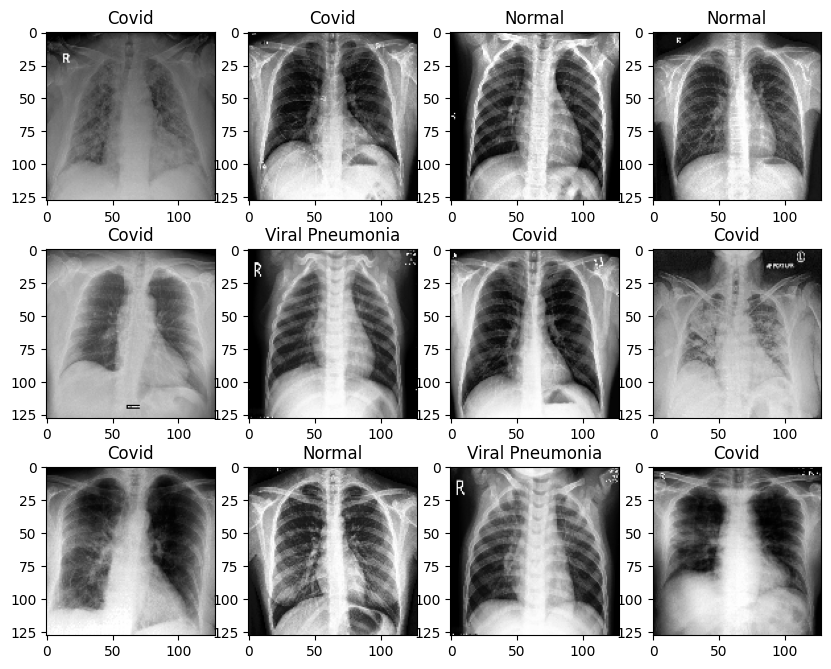

In [ ]:
def display_random_images(images, labels):
    num_classes = 3  # Number of unique classes
    unique_classes = np.unique(labels)
    label_dict = dict(labels['Label'])

    num_rows = 3
    num_cols = 4

    # Set up the figure for plotting
    figure = plt.figure(figsize=(10, 8))

    for col in range(num_cols):
        for row in range(num_rows):
            random_index = np.random.randint(0, len(labels))
            subplot_index = col * num_rows + row + 1

            # Add a subplot to the figure
            subplot = figure.add_subplot(num_rows, num_cols, subplot_index)

            # Display the random image
            subplot.imshow(images[random_index, :])

            # Set the title based on the label
            subplot.set_title(label_dict[random_index])

display_random_images(images, labels)

We can see distinct differences between the X-ray images and their respective labels. These features should be recognized by our future model in order to accurately predict the class labels. The pooling layers of a CNN, specifically max-pooling in this case, will capture the most prominent features in a local region.

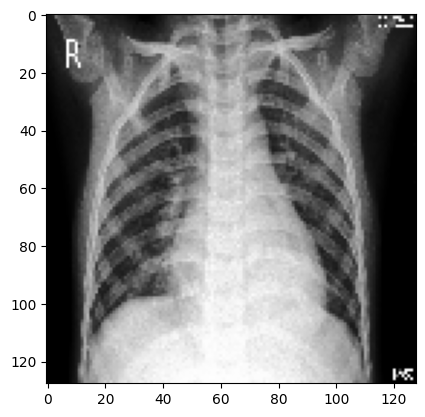

In [ ]:
plt.imshow(images[5])

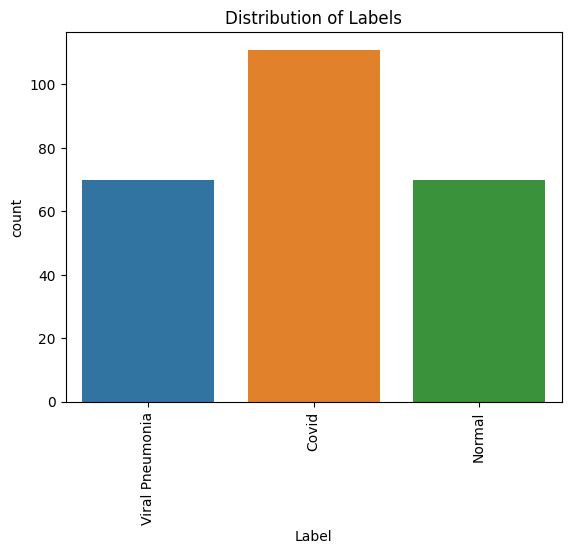

In [ ]:
sns.countplot(x='Label', data=labels)
plt.xticks(rotation='vertical')
plt.title('Distribution of Labels')
plt.show()

The graphical representation indicates an imbalance within the dataset, with approximately 110 out of the 251 images belonging to the category of Covid patients. Considering the skewed distribution, implementing data augmentation would enhance our model's performance and also improve its generalization capabilities. Given the relatively small size of the dataset, such an augmentation approach seems essential.

## Data Pre-Processing

### Converting the BGR images to RGB images

In [ ]:
images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
images_decreased = []
height = 64
width = 64
dimensions = (width, height)

for i in range(len(images)):
    resized_image = cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR)
    images_decreased.append(resized_image)

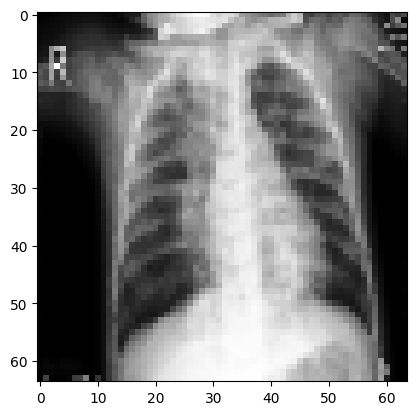

In [ ]:
plt.imshow(images_decreased[3])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(images_decreased), labels, test_size=0.1, random_state=42, stratify=labels)

### Encode the target labels

In [ ]:
label_binarizer = LabelBinarizer()

# Fitting on the training set and transforming both training and testing sets
y_train_one_hot = label_binarizer.fit_transform(y_train)
y_test_one_hot = label_binarizer.transform(y_test)

 Since this is a multiclass classification scenario, the label_binarizer ensures that each class is uniquely represented in binary vectors.

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (225, 64, 64, 3)
Shape of X_test: (26, 64, 64, 3)
Shape of y_train: (225, 1)
Shape of y_test: (26, 1)


y_train has 225 samples and each entry in the labels represents the category to which the corresponding image in X_train belongs.
Similarily, y_test has 26 samples, corresponding to the size of x_test.

### Data Normalization

We will standardize the images by dividing all pixel values by 255, ensuring that the values are within the range of 0 to 1

In [ ]:
# Normalizing the pixel values
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

## Model Building

In [ ]:
backend.clear_session()

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
num_classes = 3

# Initializing a sequential model
model = Sequential()

# Adding the first convolutional layer with 64 filters, a kernel size of 3x3, and 'same' padding to maintain input size
# The input_shape denotes the dimensions of input images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of the output of the first convolutional layer
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding='same'))

# Flattening the output of the convolutional layer after max pooling to prepare for dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

# Adding the output layer with 3 neurons (for 3 classes) and softmax activation for multi-class classification
model.add(Dense(num_classes, activation='softmax'))

# Using Adam optimizer
opt = Adam()

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



This code defines a convolutional neural network (CNN) with the following architecture:

The first convolutional layer (Conv2D) with 64 filters, a 3x3 kernel size, 'same' padding, and ReLU activation.

A max-pooling layer (MaxPooling2D) with a 2x2 pool size and 'same' padding after the first convolutional layer.

Another convolutional layer with 32 filters, a 3x3 kernel size, 'same' padding, and ReLU activation.

Another max-pooling layer after the second convolutional layer.

The output of the convolutional layers is flattened (Flatten) to prepare for dense connections.

A fully connected dense layer (Dense) with 16 neurons and ReLU activation.

A dropout layer (Dropout) with a dropout rate of 0.3 to prevent overfitting.

The output layer (Dense) with a softmax activation function, suitable for multi-class classification with three classes.

The model is compiled using the Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric.



In the code below, I'm training my model on my normalized training data and associated one-hot encoded labels and storing it in history_1. The training process runs for 30 epochs, validates on the normalized test data and its corresposnidng y_test_one_hot data, using batches of size 32, and displaying the training progress.

In [ ]:
history_1 = model.fit(
            X_train_normalized, y_train_one_hot,
            epochs=30,
            validation_data=(X_test_normalized,y_test_one_hot),
            batch_size=32,
            verbose=1
)

Epoch 1/30
8/8 [==============================] - 6s 100ms/step - loss: 1.0395 - accuracy: 0.4489 - val_loss: 0.8517 - val_accuracy: 0.5385
Epoch 2/30
8/8 [==============================] - 0s 17ms/step - loss: 0.8070 - accuracy: 0.6000 - val_loss: 0.5864 - val_accuracy: 0.7308
Epoch 3/30
8/8 [==============================] - 0s 16ms/step - loss: 0.6595 - accuracy: 0.6489 - val_loss: 0.5509 - val_accuracy: 0.8462
Epoch 4/30
8/8 [==============================] - 0s 16ms/step - loss: 0.5520 - accuracy: 0.7733 - val_loss: 0.5385 - val_accuracy: 0.7308
Epoch 5/30
8/8 [==============================] - 0s 15ms/step - loss: 0.6201 - accuracy: 0.7156 - val_loss: 0.5531 - val_accuracy: 0.8462
Epoch 6/30
8/8 [==============================] - 0s 16ms/step - loss: 0.5905 - accuracy: 0.7600 - val_loss: 0.3584 - val_accuracy: 0.8462
Epoch 7/30
8/8 [==============================] - 0s 14ms/step - loss: 0.5058 - accuracy: 0.7911 - val_loss: 0.2965 - val_accuracy: 0.9231
Epoch 8/30
8/8 [==========

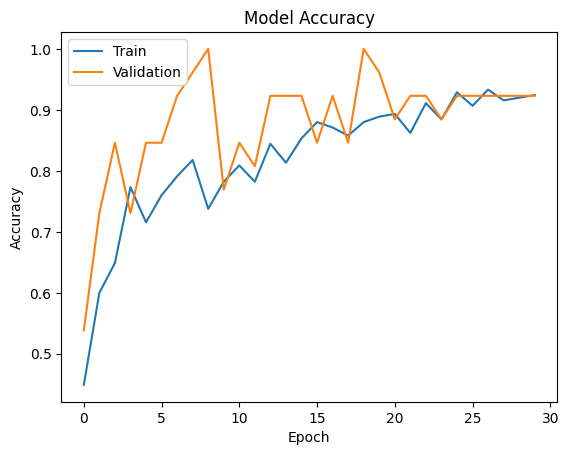

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The above graph is showing a positive result between the training and testing data. The model does not appear overfit which is a promising starting point.


Next step here is to evaluate my model's performance on the normalized test data using one-hot encoded labels and then calculating the accuracy.

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_one_hot, verbose=1)

1/1 [==============================] - 0s 27ms/step - loss: 0.2099 - accuracy: 0.9231


In [ ]:
y_pred = model.predict(X_test_normalized)

1/1 [==============================] - 0s 92ms/step


In [ ]:
y_pred

array([[2.8262136e-04, 1.8713543e-02, 9.8100382e-01],
       [9.9999356e-01, 6.3366710e-06, 1.1373476e-07],
       [9.9997973e-01, 1.4112581e-05, 6.2492645e-06],
       [9.9993169e-01, 4.8214657e-05, 2.0186935e-05],
       [3.5486080e-02, 9.6448916e-01, 2.4688836e-05],
       [9.9999034e-01, 9.5517835e-06, 9.3118921e-08],
       [9.9476177e-01, 3.5068828e-03, 1.7313954e-03],
       [4.8530016e-02, 9.5067328e-01, 7.9671346e-04],
       [4.5662162e-01, 5.4199165e-01, 1.3867517e-03],
       [9.9999869e-01, 1.2874236e-06, 2.5288647e-09],
       [1.7297093e-04, 1.4766311e-02, 9.8506075e-01],
       [9.9999964e-01, 3.0701514e-07, 3.0229611e-08],
       [1.4111982e-01, 8.5887915e-01, 1.0216115e-06],
       [1.0523712e-03, 3.5168946e-02, 9.6377867e-01],
       [2.5566218e-02, 8.6086589e-01, 1.1356787e-01],
       [3.6551875e-05, 6.9571994e-03, 9.9300623e-01],
       [1.0000000e+00, 1.5059264e-08, 5.2111218e-11],
       [1.0000000e+00, 6.8727859e-09, 5.0560840e-11],
       [9.9899155e-01, 9.584

Checking the predicted probabilities into class labels based on the original class labels.

In [ ]:
predicted_probs = np.array([
    [2.27981991e-06, 1.04331307e-03, 9.98954415e-01],
    [9.99967813e-01, 3.08944436e-05, 1.34979223e-06]
])

# original class labels before one-hot encoding
original_labels = ['Covid', 'Normal', 'Viral Pneumonia']

# Getting the index of the maximum probability for each row
predicted_classes = np.argmax(predicted_probs, axis=1)

# Mapping the predicted class indices to original class labels
predicted_class_labels = [original_labels[idx] for idx in predicted_classes]

# Printing the results
for i, class_label in enumerate(predicted_class_labels):
    print(f"Sample {i+1}: Predicted Class - {class_label}")

Sample 1: Predicted Class - Viral Pneumonia
Sample 2: Predicted Class - Covid


We can see here that sample 1 predicted Viral pheumonia and sample 2 predicted Covid. Next step is to compare these predicted labels with actual labels.

In [ ]:
true_labels_strings = ['Normal', 'Covid', 'Viral Pheumonia']

# Printing the predicted and true class labels for each sample
for i, class_label in enumerate(predicted_class_labels):
    true_class_label = true_labels_strings[i]
    accuracy_status = "Accurate" if class_label == true_class_label else "Inaccurate"
    print(f"Sample {i+1}: Predicted Class - {class_label}, True Class - {true_class_label}, Accuracy - {accuracy_status}")

Sample 1: Predicted Class - Viral Pneumonia, True Class - Normal, Accuracy - Inaccurate
Sample 2: Predicted Class - Covid, True Class - Covid, Accuracy - Accurate


Unfortunately. our model exhibited an inaccurate prediction for the 1st sample; however, it did achieve an accurate prediction for the 2nd sample.

1/1 [==============================] - 0s 18ms/step


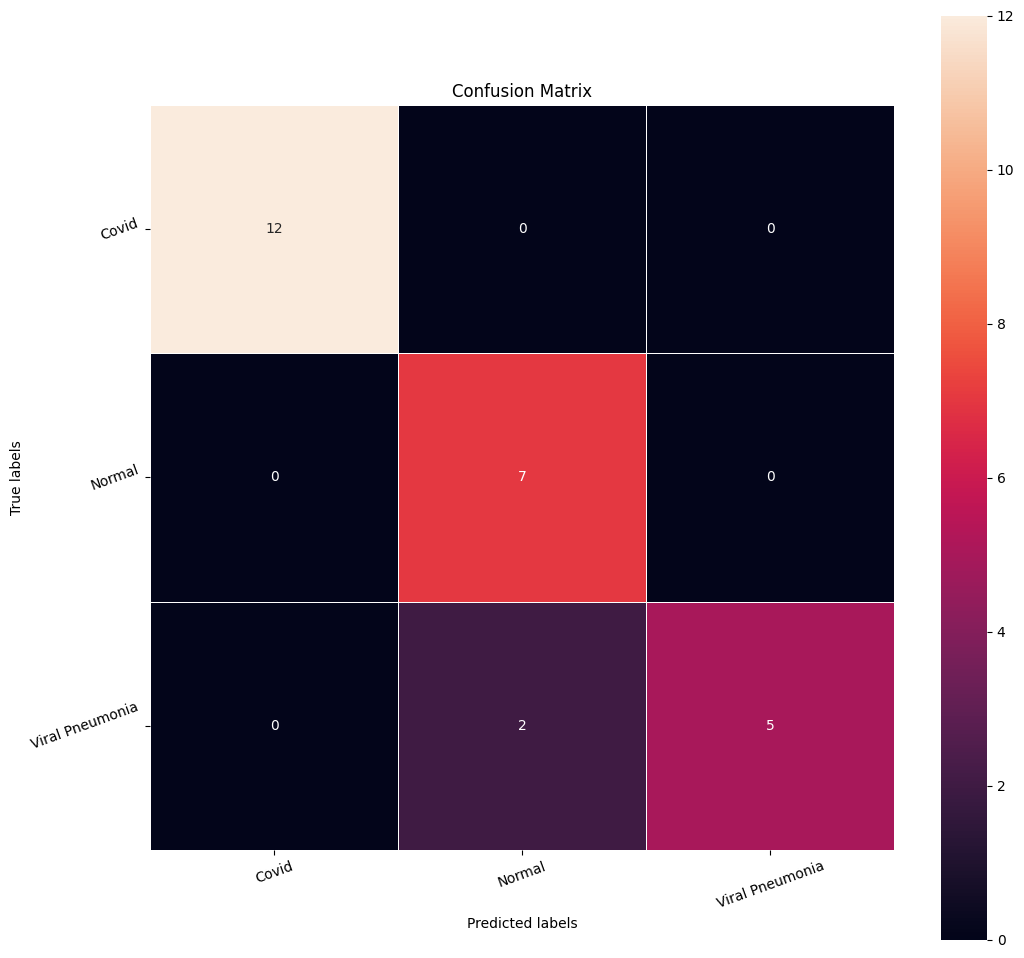

In [ ]:
y_true = np.argmax(y_test_one_hot, axis=1)
y_pred = np.argmax(model.predict(X_test_normalized), axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the Confusion Matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    conf_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation=20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation=20)

plt.show()

Our model accurately predicted all Covid samples, made one incorrect prediction for Viral Pneumonia, and correctly labeled all 'Normal' samples.

In [ ]:
# Generating the Classification Report
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.78      1.00      0.88         7
           2       1.00      0.71      0.83         7

    accuracy                           0.92        26
   macro avg       0.93      0.90      0.90        26
weighted avg       0.94      0.92      0.92        26




Although the aforementioned report indicates excellent metrics for precision, recall, accuracy, and F1-score, it's worth considering improvements to our model, particularly through data augmentation, as incorporating more samples can enhance generalization.

In [ ]:
del model
del history_1

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


It is now time to prepare the generators for training and testing images. For training, we are rotating the images up to 20 degrees and will use the 'nearest' pixel filling. For testing, we are rescaling pixel values to be between 0 and 1. Hopefully our model will improve on learning and generalization.

In [ ]:
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
batch_size = 32
# Checking the size of the augmented training set
augmented_batches = train_datagen.flow(X_train_normalized, y_train_one_hot, batch_size=batch_size)
augmented_train_size = augmented_batches.n * augmented_batches.batch_size

print(f"Augmented training set size: {augmented_train_size} samples")

Augmented training set size: 7200 samples


In [ ]:
original_train_size = X_train_normalized.shape[0]

# checking original training set size)
print(f"Original training set size: {original_train_size} samples")

Original training set size: 225 samples


After the data augmentation just performed, it's time to build our 2nd model

In [ ]:
# Initializing a sequential model
model_1 = Sequential()

# Adding the first convolutional layer with 64 filters, a kernel size of 3x3, and 'same' padding to maintain input size
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of the output of the first convolutional layer
model_1.add(MaxPooling2D((2, 2), padding='same'))

model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding='same'))

# Flattening the output of the convolutional layer after max pooling to prepare for dense connections
model_1.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model_1.add(Dense(16, activation='relu'))
model_1.add(Dropout(0.3))

# Adding the output layer with 3 neurons (for 3 classes) and softmax activation for multi-class classification
model_1.add(Dense(num_classes, activation='softmax'))

# Using Adam optimizer
opt = Adam()

# Compiling model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

We are working with a Sequential model in Keras for a convolutional neural network (CNN) with two convolutional layers, each followed by max-pooling, a flattening layer and additional dense layers for classification. After flattening, there is a dense layer with 16 units and a dropout layer for regularization. Finally, there is an output dense layer with 3 units, representing the number of classes. The model has a total of 151,395 parameters and is ready for training on a dataset with images of size 64x64 pixels and 3 color channels.

In [ ]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model_1.fit(train_datagen.flow(X_train_normalized, y_train_one_hot,
                                           batch_size=batch_size,
                                           shuffle=False),
                       epochs=epochs,
                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                       validation_data=(X_test_normalized, y_test_one_hot),
                       verbose=1)

Epoch 1/30
3/3 [==============================] - 2s 251ms/step - loss: 1.0999 - accuracy: 0.3789 - val_loss: 1.0250 - val_accuracy: 0.4615
Epoch 2/30
3/3 [==============================] - 0s 181ms/step - loss: 1.0067 - accuracy: 0.4534 - val_loss: 0.9428 - val_accuracy: 0.7692
Epoch 3/30
3/3 [==============================] - 0s 181ms/step - loss: 0.9396 - accuracy: 0.5652 - val_loss: 0.7869 - val_accuracy: 0.7308
Epoch 4/30
3/3 [==============================] - 0s 138ms/step - loss: 0.8657 - accuracy: 0.5901 - val_loss: 0.6282 - val_accuracy: 0.7692
Epoch 5/30
3/3 [==============================] - 0s 174ms/step - loss: 0.7174 - accuracy: 0.6708 - val_loss: 0.5330 - val_accuracy: 0.7308
Epoch 6/30
3/3 [==============================] - 1s 176ms/step - loss: 0.6307 - accuracy: 0.7329 - val_loss: 0.4933 - val_accuracy: 0.9231
Epoch 7/30
3/3 [==============================] - 0s 158ms/step - loss: 0.6023 - accuracy: 0.7081 - val_loss: 0.4039 - val_accuracy: 0.7692
Epoch 8/30
3/3 [====

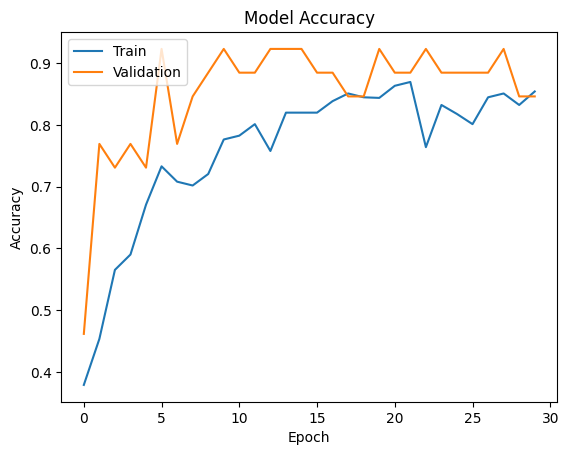

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

model_1 is displaying satisfactory results here, with training and validation overlapping at ca 82/83%, indicating a well performing model.

In [ ]:
accuracy = model_1.evaluate(X_test_normalized, y_test_one_hot, verbose=1)

1/1 [==============================] - 0s 27ms/step - loss: 0.3354 - accuracy: 0.8462


In [ ]:
y_pred = model_1.predict(X_test_normalized)

1/1 [==============================] - 0s 70ms/step


In [ ]:
y_pred

array([[4.8655258e-03, 5.0171997e-02, 9.4496250e-01],
       [9.9880099e-01, 1.1766198e-03, 2.2333452e-05],
       [9.9924207e-01, 4.9684983e-04, 2.6114844e-04],
       [9.9312383e-01, 4.5804163e-03, 2.2958326e-03],
       [6.2112629e-02, 9.2089516e-01, 1.6992146e-02],
       [9.6312070e-01, 3.6376510e-02, 5.0272822e-04],
       [9.7146356e-01, 2.0499462e-02, 8.0370735e-03],
       [9.9240892e-02, 8.9809048e-01, 2.6686480e-03],
       [1.6642730e-01, 8.2209694e-01, 1.1475811e-02],
       [9.9869078e-01, 1.2902934e-03, 1.8886099e-05],
       [9.6098026e-03, 1.9170392e-01, 7.9868633e-01],
       [9.9967825e-01, 2.8717169e-04, 3.4540670e-05],
       [4.8891291e-02, 9.5086426e-01, 2.4449677e-04],
       [2.6416456e-02, 2.0894229e-01, 7.6464123e-01],
       [7.0592575e-02, 8.4785646e-01, 8.1550926e-02],
       [5.1733232e-03, 8.3310463e-02, 9.1151619e-01],
       [9.9999642e-01, 3.5978053e-06, 5.0183537e-08],
       [9.9999619e-01, 3.6677363e-06, 1.2768480e-07],
       [8.0146235e-01, 1.894

Let's take a peek at the first two predicted probabilities and figure out whether it is indeed correctly labeled by the model.

In [ ]:
predicted_probs = np.array([
    [4.8655258e-03, 5.0171997e-02, 9.4496250e-01],
    [9.9880099e-01, 1.1766198e-03, 2.2333452e-05],
])

# Sample true labels
true_labels_strings = ['Normal', 'Covid', 'Viral Pheumonia']

# Get the index of the maximum probability for each row
predicted_classes = np.argmax(predicted_probs, axis=1)

# Map the predicted class indices to original class labels
predicted_class_labels = [true_labels_strings[idx] for idx in predicted_classes]

# Printing the predicted and true class labels along with accuracy status for each sample
for i, (predicted_label, true_label) in enumerate(zip(predicted_class_labels, true_labels_strings)):
    accuracy_status = "Accurate" if predicted_label == true_label else "Inaccurate"
    print(f"Sample {i+1}: Predicted Class - {predicted_label}, True Class - {true_label}, Accuracy - {accuracy_status}")

Sample 1: Predicted Class - Viral Pheumonia, True Class - Normal, Accuracy - Inaccurate
Sample 2: Predicted Class - Normal, True Class - Covid, Accuracy - Inaccurate


Both samples were incorrectly labeled in this case.

1/1 [==============================] - 0s 20ms/step


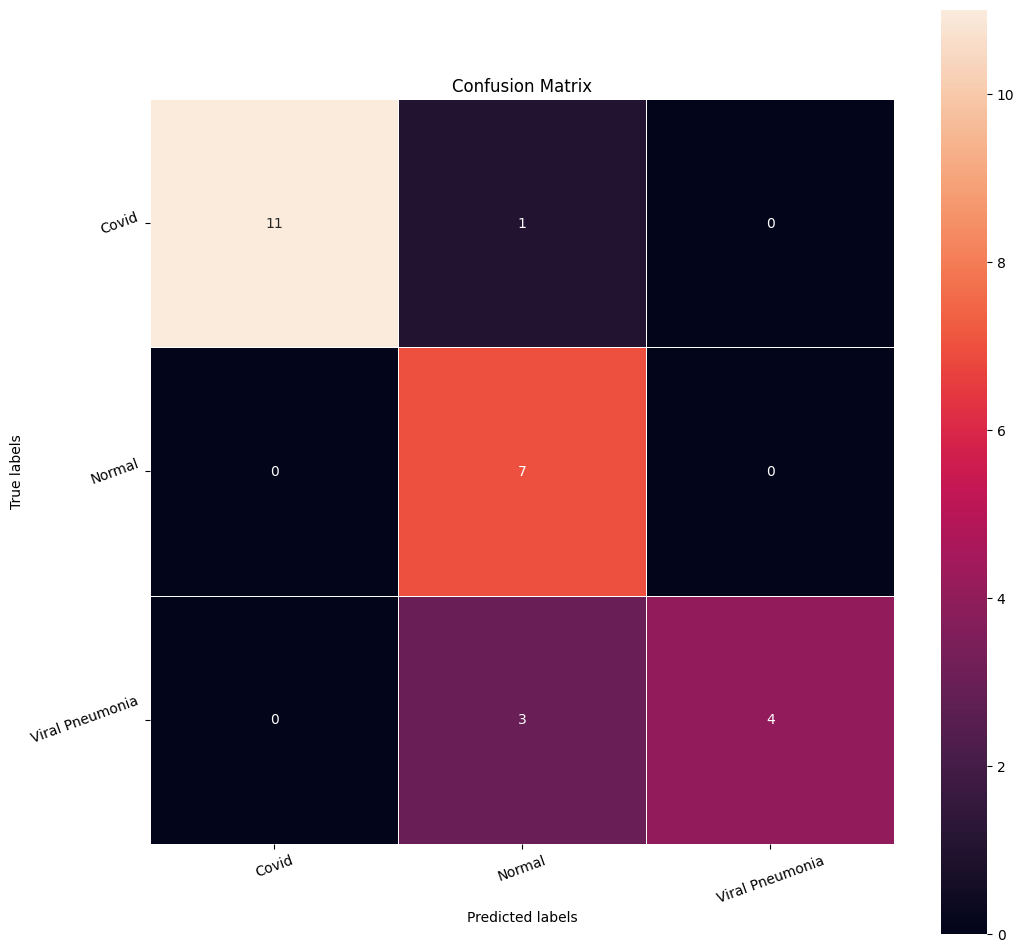

In [ ]:
# Getting the true labels
y_true = np.argmax(y_test_one_hot, axis=1)

# Predict using model_1 on augmented data
y_pred_probs = model_1.predict(X_test_normalized)
y_pred = np.argmax(y_pred_probs, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the Confusion Matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    conf_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation=20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation=20)

plt.show()

In [ ]:
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.64      1.00      0.78         7
           2       1.00      0.57      0.73         7

    accuracy                           0.85        26
   macro avg       0.88      0.83      0.82        26
weighted avg       0.90      0.85      0.85        26



Recall is very good for class 0 and class 1. Improvement in predicting class 2 is needed (but not our main focus here). Accuracy sits at 85% and we can observe 3 cases of mislabeling x-ray images as 'normal' when the cases were in fact 'viral pneomonia'. Only 1 Covid image was incorrectly labeled as normal.

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

I am selecting model_1 as it is essential to prioritize robustness and generalization over immediate performance metrics. Despite the lower performance metrics compared to the original model, the integration of data augmentation techniques in model_1 enhances its ability to handle variations and unseen scenarios in real-world data. model_ 1 may exhibit improved performance when faced with diverse and previously unseen examples.

### Visualizing the prediction

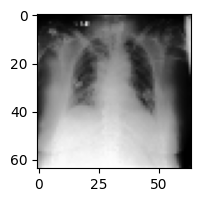

1/1 [==============================] - 0s 86ms/step
Predicted Label (2): Covid
True Label (2): Covid


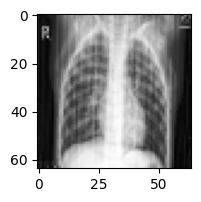

1/1 [==============================] - 0s 32ms/step
Predicted Label (10): Viral Pneumonia
True Label (10): Viral Pneumonia


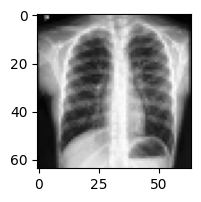

1/1 [==============================] - 0s 35ms/step
Predicted Label (25): Normal
True Label (25): Normal


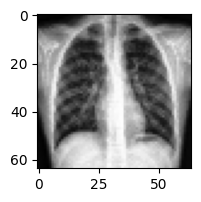

1/1 [==============================] - 0s 30ms/step
Predicted Label (20): Normal
True Label (20): Normal


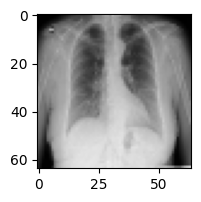

1/1 [==============================] - 0s 41ms/step
Predicted Label (5): Covid
True Label (5): Covid


In [ ]:
label_binarizer = LabelBinarizer()

# Fitting on the training set and transforming both training and testing sets
y_train_one_hot = label_binarizer.fit_transform(y_train)
y_test_one_hot = label_binarizer.transform(y_test)

# Visualizing and predicting for multiple indices
visualize_and_predict(2, model_1, X_test_normalized, X_test, y_test_one_hot, label_binarizer)
visualize_and_predict(10, model_1, X_test_normalized, X_test, y_test_one_hot, label_binarizer)
visualize_and_predict(25, model_1, X_test_normalized, X_test, y_test_one_hot, label_binarizer)
visualize_and_predict(20, model_1, X_test_normalized, X_test, y_test_one_hot, label_binarizer)
visualize_and_predict(5, model_1, X_test_normalized, X_test, y_test_one_hot, label_binarizer)

## Actionable Insights and Business Recommendations

 **Prioritize Model Robustness**:

Continue using model_1 for its focus on robustness and generalization.

**Address Imbalanced Data**:

Explore strategies to balance the dataset, especially for class 1.

**Improve Class 1 Performance:**

Refine the model to enhance its ability to identify instances in class 1.

**Integration with Existing Healthcare Systems:**

Explore seamless integration of the model with existing healthcare systems to streamline diagnostic workflows and enhance accessibility for medical professionals.

**Collaboration with Radiologists:**

Foster collaboration with radiologists to leverage their expertise in image interpretation, incorporating their feedback for continuous model refinement.

**Significance of Expanding COVID-19 Dataset:**
It is important to consistently enrich the COVID-19 dataset with diverse cases, encompassing variations in patient demographics, disease manifestations, and geographical locations. A continually growing dataset ensures that the model remains effective in capturing the evolving nature of COVID-19 and improves its diagnostic accuracy over time.

In [ ]:
!jupyter nbconvert --to html /content/drive/MyDrive/Colab_Notebooks/High_Code_COVID_19_Emma-Campodonico.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/High_Code_COVID_19_Emma-Campodonico.ipynb to html
[NbConvertApp] Writing 1731104 bytes to /content/drive/MyDrive/Colab_Notebooks/High_Code_COVID_19_Emma-Campodonico.html


In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/Colab_Notebooks/High_Code_COVID_19_Emma-Campodonico.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

_____